In [3]:
import os.path
import time
import pylab as pl
import numpy as np
from scipy import rand
from scipy.io import loadmat
%pylab inline
import os
import time
from scipy.io import savemat, loadmat
from numpy import *
import copy
import pandas as pd
from scipy.io import loadmat
import seaborn as sns
import scipy
from scipy.signal import savgol_filter
from scipy.signal import argrelextrema
from scipy.signal import find_peaks_cwt
from scipy.signal import find_peaks
from scipy import interpolate
import math
def truncate(number, digits) -> float:
    stepper = 10.0 ** digits
    return math.trunc(stepper * number) / stepper
sns.set()

Populating the interactive namespace from numpy and matplotlib


In [10]:
dSet = 'GEMS-grace_dropletsAndNuclei'
##########################################
dx = 0.11029266566038132
frame = 50
cellCycle = 4 #0=G1, 1=S/G2, 2=M, 3=Unknown, 4=All
##########################################
dtDict = {'gems_908.2034': 0.8646714091300964, 'gems_908.2026': 1.5261081457138062, 
          'gems_908.2030': 0.8987785577774048, 'gems_908.3017': 0.861128568649292}
nest = np.load('axialData-{0}.npy'.format(dSet),allow_pickle=True,
               encoding='latin1')[0] #b/c file was made w/ python 2
# nest = np.load('axialDataLinkerModified-{0}.npy'.format(dSet),allow_pickle=True,
#                encoding='latin1')[0] #b/c file was made w/ python 2
vids = nest.keys()
sorted(vids)
##########################################
nucDiffs = []
allDiffs = []
allWeights = []
nucWeights = []
ratioNucToAll = []
nucCounter = 0
counter = 0
for v in vids:
    for hy in arange(len(nest[v]['diffusivity'])): 
        allNucLoc = []
        diffsZeros = []
        diffs = []
        ###############
        if v == 'gems_908.2034':
            if hy == 15 or hy == 16 or hy == 17: #too far out of the plane
                continue
        ############### fixing errors:
        if len(nest[v]['arcLength'][hy]) < 20: 
            continue
        if len(shape(nest[v]['nucleiMedialAxisPosition'][hy])) <= 1: 
            continue                         
        ###############
        diffsZeros = nest[v]['diffusivity'][hy][frame,:]*(dx**2/dtDict[v]) 
        diffs = array([i for i in diffsZeros if i!=0])                                                          
        if len(diffs) == 0:  
            continue            
        ###############
        AL = abs(nest[v]['arcLength'][hy])*dx 
        ###############
        if cellCycle != 4:
            allNucLocIdxTemp = nest[v]['nucleiMedialAxisPosition'][hy]
            allNucLocIdx = [k for k in allNucLocIdxTemp[0] if 
                    allNucLocIdxTemp[1][allNucLocIdxTemp[0].tolist().index(k)]==cellCycle]
        if cellCycle == 4:
            allNucLocIdx = nest[v]['nucleiMedialAxisPosition'][hy][0] 
        ###############
        allNucLoc = AL[allNucLocIdx]
        #####
        allDiffs = append(allDiffs, diffs)
        nucDiffs = append(nucDiffs, diffs[allNucLocIdx])
        ####           
        diffAL = np.diff(AL)
        weights = np.zeros(len(AL))
        weights[0] = diffAL[0]
        weights[-1] = diffAL[-1]
        for i, val in enumerate(weights[1:-1],1):
            weights[i] = (diffAL[i-1] + diffAL[i])/2
        allWeights = append(allWeights,weights)
        nucWeights = append(nucWeights,weights[allNucLocIdx])
        for i,val in enumerate(diffs[allNucLocIdx]):
            ratioNucToAll = append(ratioNucToAll,val/np.average(diffs,weights=weights))
        ###############
#         sns.set(font_scale=1.5)
#         plt.figure(figsize=(8,3))
#         xlabel('medial axis (um)')
#         ylim([-0.02,0.12])
#         xlim([0,70])
#         plot(AL, diffs, linewidth=5,color=[0.35,0.35,0.35]) #medial axis plots     
#         scatter(allNucLoc, zeros(len(allNucLoc)), linewidth=2.5,s=150,c='c')
#         for xc in allNucLoc:
#             plt.axvline(x = xc, color='c', linestyle='--',alpha=0.4)
        #####
        counter += 1
        nucCounter += len(allNucLoc)
        #####
#         plt.savefig('nucleiLocs-{0}.pdf'.format(counter))

0.061900158930974274
9458
353
0.06045352285986491


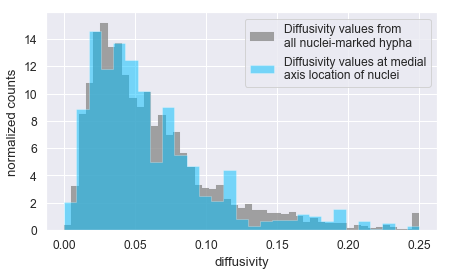

In [5]:
fig = plt.figure(1,figsize=(7,4))
sns.set(font_scale=1.1)
######
plt.hist(np.clip(allDiffs,0,0.25),color=[0.55,0.55,0.55],bins=linspace(0,0.25,50),lw=0.4,alpha=.8,
         weights=allWeights,density=True,histtype='stepfilled', linewidth=0.05,
         edgecolor=[0.55,0.55,0.55],label='Diffusivity values from\nall nuclei-marked hypha')
plt.hist(np.clip(nucDiffs,0,0.25),color='deepskyblue',bins=linspace(0,0.25,30),lw=0.4,alpha=0.5,
         weights=nucWeights,density=True,histtype='stepfilled', linewidth=0.5,
         label='Diffusivity values at medial\naxis location of nuclei',edgecolor='w')
######
plt.legend()
xlabel('diffusivity')
ylabel('normalized counts')
title('')
# fig.savefig('allDiffsAndNuc.pdf')
print(mean(allDiffs))
print(len(allDiffs))
print(len(nucDiffs))

print(mean(nucDiffs))


/Users/gracemclaughlin/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 1.0, ', median=0.91, 59%<1.0')

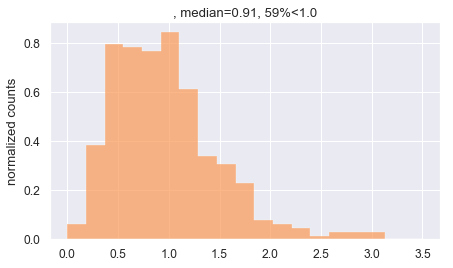

In [6]:
fig = plt.figure(1,figsize=(7,4))
plt.hist(ratioNucToAll,color=[0.984, 0.6, 0.337],lw=0.4,alpha=0.7,bins=linspace(0,3.5,20),
        histtype='stepfilled',normed=True,label='Ratio of Diffusivity at tips')
ylabel('normalized counts')
perLess1 = 100*len(ratioNucToAll[ratioNucToAll<1])/len(ratioNucToAll)
title(', median={0}, {1}%<1.0'.format(round(np.median(ratioNucToAll),2),round(perLess1)))
# fig.savefig('ratioNuc.pdf')

In [9]:
# G1Ratio = ratioNucToAll
# SG2Ratio = ratioNucToAll
# mRatio = ratioNucToAll

/Users/gracemclaughlin/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/Users/gracemclaughlin/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


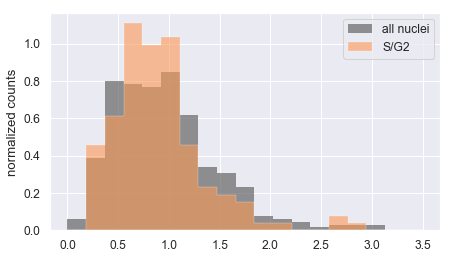

In [13]:
fig = plt.figure(1,figsize=(7,4))
plt.hist(ratioNucToAll,color=[0.4, 0.4, 0.4],lw=0,alpha=0.7,bins=linspace(0,3.5,20),
        histtype='stepfilled',normed=True,label='all nuclei')
# plt.hist(mRatio,color=[0.7, 0.7, 0.7],lw=0,alpha=0.6,bins=linspace(0,3.5,20),
#         histtype='stepfilled',normed=True,label='M')
plt.hist(SG2Ratio,color=[0.984, 0.6, 0.337],lw=0.4,alpha=0.6,bins=linspace(0,3.5,20),
        histtype='stepfilled',normed=True,label='S/G2')
ylabel('normalized counts')
perLess1 = 100*len(ratioNucToAll[ratioNucToAll<1])/len(ratioNucToAll)
# title(', median={0}, {1}%<1.0'.format(round(np.median(ratioNucToAll),2),round(perLess1)))
plt.legend()